In [2]:

from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import itertools

import keras
from keras.applications import ResNet50, Xception
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
#from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import pickle
from datetime import datetime

np.random.seed(123)
from config import config
from utils.load_data import load_skin_data
import tensorflow as tf
from stratified_cross_validator import StratifiedCrossValidator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from tensorflow.keras.applications.resnet50 import preprocess_input  # pour ResNet50
#from tensorflow.keras.applications.xception import preprocess_input  # pour Xception


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, VGG16, Xception, MobileNetV2

from tensorflow.keras import optimizers, callbacks
import time

from utils.load_data import load_skin_data

In [3]:
tf.version.VERSION

'2.19.0'

In [2]:


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
    
df = load_skin_data(
        dataset_dir=config.DATASET_DIR,
        metadata_path=config.METADATA_PATH,
        lesion_type_dict=lesion_type_dict
    )
    
    
    # Display the shape of the dataframe
print(f"Dataframe shape: {df.shape}")
    


Dataframe shape: (10015, 10)


In [3]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

0 images non trouvées dans le dossier


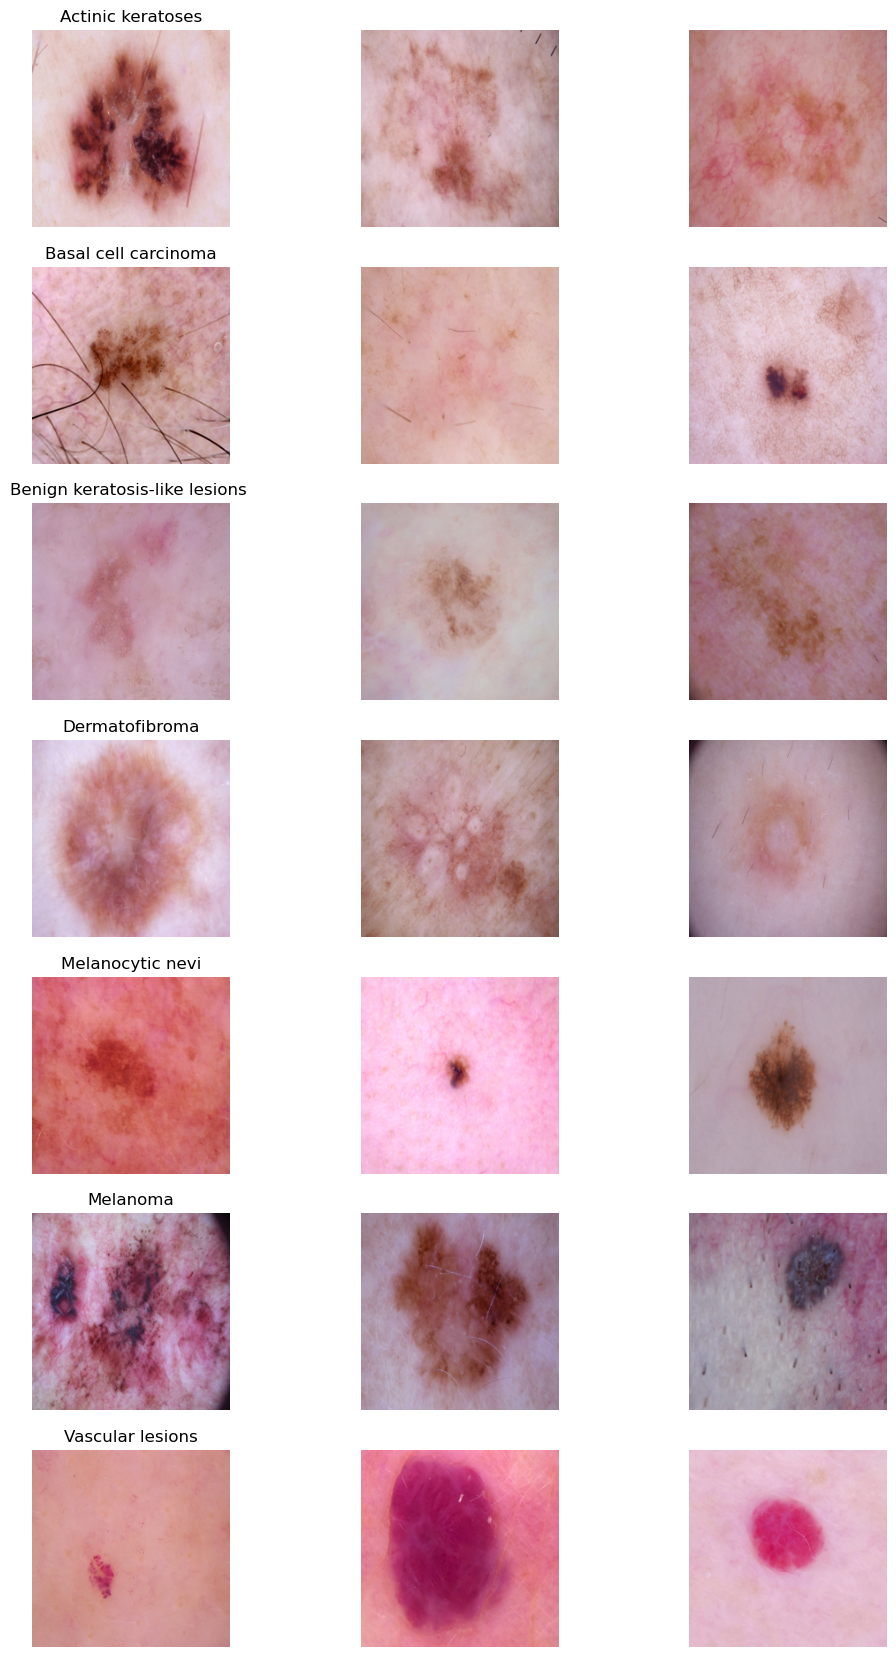

In [4]:
print(df['path'].isnull().sum(), "images non trouvées dans le dossier")
img = df.sample(n=500,replace=False, random_state=1)
img['image'] = img['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))
#Image Sampling
n_samples = 3

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))

for n_axs, (type_name, type_rows) in zip(m_axs,img.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [5]:
def handle_missing_values(df):
    df = df.copy()

    if 'age' in df.columns:
        median_age = df['age'].median()
        df['age'].fillna(median_age, inplace=True)

    if 'sex' in df.columns:
        df['sex'] = df['sex'].replace(['unknown', 'Unknown'], np.nan)

        # Remplir les valeurs manquantes avec le mode
        if df['sex'].isnull().any():
            mode_sex = df['sex'].mode()[0]
            df['sex'].fillna(mode_sex, inplace=True)

    return df


In [6]:

def path_to_image_array(df):
    
    df["image"] = df["path"].map(lambda x: np.asarray(Image.open(x).resize((224, 224))))
    

In [7]:
from tensorflow.keras.applications.resnet50 import preprocess_input  # pour ResNet50
#from tensorflow.keras.applications.xception import preprocess_input  # pour Xception

In [8]:
from sklearn.metrics import f1_score, matthews_corrcoef


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, Xception



class MultimodalCNNFramework:
    """
    Framework CNN multimodal combinant images et métadonnées 
    pour la prediction  du cancer et la sélection de l'équité avec sélection du meilleur modèle.
    """
    
    def __init__(self, input_shape=(224, 224, 3), num_classes=7, 
                 batch_size=32, epochs=100, learning_rate=0.001,
                 metadata_cols=None):
        """
        Initialise le framework CNN multimodal.
        
        Args:
            input_shape: Forme des images (hauteur, largeur, canaux)
            num_classes: Nombre de classes à prédire
            batch_size: Taille des batches
            epochs: Nombre d'époques d'entraînement
            learning_rate: Taux d'apprentissage initial
            metadata_cols: Liste des colonnes de métadonnées à utiliser
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.metadata_cols = metadata_cols or []
        
        self.architectures = {}
        self.training_history = {}
        self.evaluation_results = []
        
        # initialisation des gpt si disponible
        self._setup_gpu()
        
    def _setup_gpu(self):
        """
        Configure l'utilisation du GPU si disponible.
        """
        devices_gpu = tf.config.experimental.list_physical_devices('GPU')
        
        if devices_gpu:
            try:
                for device in devices_gpu:
                    tf.config.experimental.set_memory_growth(device, True)
                print(f" GPU configuré: {len(devices_gpu)} GPU(s) disponible(s)")
            except RuntimeError as e:
                print(f"  Erreur configuration GPU: {e}")
   
   
    def prepare_metadata(self, X_train, X_test, X_val, target_col: str, transform_columns: list, save_dir: str = "encoders", fold_number: int = 0):

        os.makedirs(f'{save_dir}/fold_{fold_number}', exist_ok=True)

        # Encodage de la cible
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(X_train[target_col])
        y_val = label_encoder.transform(X_val[target_col])
        
        
        y_test = label_encoder.transform(X_test[target_col])

        # Gestion des valeurs manquantes
        X_train = handle_missing_values(X_train)
        X_val = handle_missing_values(X_val)
        X_test = handle_missing_values(X_test)

        # One-hot encoding
        onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        col_train = onehot_encoder.fit_transform(X_train[transform_columns])
        col_val = onehot_encoder.transform(X_val[transform_columns])
        col_test = onehot_encoder.transform(X_test[transform_columns])

        # Standardisation de l'âge
        scaler_age = StandardScaler()
        age_train = scaler_age.fit_transform(X_train[['age']])
        age_val = scaler_age.transform(X_val[['age']])
        age_test = scaler_age.transform(X_test[['age']])

        # Combinaison des features
        X_train_tab = np.concatenate([col_train, age_train], axis=1)
        X_val_tab = np.concatenate([col_val, age_val], axis=1)
        X_test_tab = np.concatenate([col_test, age_test], axis=1)

        # Sauvegarde
        joblib.dump(label_encoder, os.path.join(f'{save_dir}/fold_{fold_number}/', f"{fold_number}_label_encoder.pkl"))
        joblib.dump(onehot_encoder, os.path.join(f'{save_dir}/fold_{fold_number}/', f"{fold_number}_onehot_encoder.pkl"))
        joblib.dump(scaler_age, os.path.join(f'{save_dir}/fold_{fold_number}/', f"{fold_number}_scaler_age.pkl"))
    
        X_train.to_csv(os.path.join(f'{save_dir}/fold_{fold_number}/', f"X_train.csv"), index=False)
        X_val.to_csv(os.path.join(f'{save_dir}/fold_{fold_number}/', f"X_val.csv"), index=False)
        X_test.to_csv(os.path.join(f'{save_dir}/fold_{fold_number}/', f"X_test.csv"), index=False),

        # Retour
        X_dict = {"train": X_train_tab, "val": X_val_tab, "test": X_test_tab}
        y_dict = {"train": y_train, "val": y_val, "test": y_test}
        transformers = {
            "label_encoder": label_encoder,
            "onehot_encoder": onehot_encoder,
        "scaler_age": scaler_age
        }

        return X_dict, y_dict, transformers
    
    
    def preprocess_image_data_with_pretrained(self, train_df, test_df, val_df, preprocess_func):
        """
            Prétraitement des images déjà chargées (présentes dans la colonne 'image').

        Args:
            train_df, test_df, val_df : DataFrames contenant une colonne 'image'
            preprocess_func : fonction Keras (ex : preprocess_input)

        Returns:
            x_train, x_test, x_val : tableaux numpy prétraités
        """
    # Stack les images (shape attendue : (N, H, W, 3))
        x_train = np.stack(train_df["image"].values)
        x_test = np.stack(test_df["image"].values)
        x_val = np.stack(val_df["image"].values)

        # Appliquer le prétraitement
        if preprocess_func:
            x_train = preprocess_func(x_train.astype(np.float32))
            x_test = preprocess_func(x_test.astype(np.float32))
            x_val = preprocess_func(x_val.astype(np.float32))

        return x_train, x_test, x_val


         
        
    def create_multimodal_resnet(self, metadata_dim, name="MultimodalResNet"):
        """Crée un modèle ResNet multimodal."""
        # Branche image
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )
        
        # Fine-tuning
        base_model.trainable = True
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        
        image_input = layers.Input(shape=self.input_shape, name='image_input')
        x = base_model(image_input)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        image_features = layers.Dense(512, activation='relu', name='image_features')(x)
        
        # Branche métadonnées
        if metadata_dim > 0:
            metadata_input = layers.Input(shape=(metadata_dim,), name='metadata_input')
            meta_x = layers.Dense(128, activation='relu')(metadata_input)
            meta_x = layers.BatchNormalization()(meta_x)
            meta_x = layers.Dropout(0.3)(meta_x)
            meta_x = layers.Dense(64, activation='relu')(meta_x)
            meta_features = layers.BatchNormalization()(meta_x)
            
            # Fusion des branches
            combined = layers.concatenate([image_features, meta_features])
            combined = layers.Dense(256, activation='relu')(combined)
            combined = layers.BatchNormalization()(combined)
            combined = layers.Dropout(0.4)(combined)
            
            outputs = layers.Dense(self.num_classes, activation='softmax')(combined)
            model = models.Model(inputs=[image_input, metadata_input], outputs=outputs)
        else:
            # Modèle image uniquement
            x = layers.Dense(256, activation='relu')(image_features)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.3)(x)
            outputs = layers.Dense(self.num_classes, activation='softmax')(x)
            model = models.Model(inputs=image_input, outputs=outputs)
        
        self.architectures[name] = model
        print(f"model ok {name} créé - Paramètres: {model.count_params():,}")
        return model
    

    def create_multimodal_xception(self, metadata_dim, name="MultimodalXception"):
        """Crée un modèle Xception multimodal."""

        # Branche image (Xception)
        base_model = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )

        # Fine-tuning
        base_model.trainable = True
        for layer in base_model.layers[:-20]:  
            layer.trainable = False

        image_input = layers.Input(shape=self.input_shape, name='image_input')
        x = base_model(image_input)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        image_features = layers.Dense(512, activation='relu', name='image_features')(x)

        # Branche métadonnées
        if metadata_dim > 0:
            metadata_input = layers.Input(shape=(metadata_dim,), name='metadata_input')
            meta_x = layers.Dense(128, activation='relu')(metadata_input)
            meta_x = layers.BatchNormalization()(meta_x)
            meta_x = layers.Dropout(0.3)(meta_x)
            meta_x = layers.Dense(64, activation='relu')(meta_x)
            meta_features = layers.BatchNormalization()(meta_x)

        # Fusion des branches
            combined = layers.concatenate([image_features, meta_features])
            combined = layers.Dense(256, activation='relu')(combined)
            combined = layers.BatchNormalization()(combined)
            combined = layers.Dropout(0.4)(combined)

            outputs = layers.Dense(self.num_classes, activation='softmax')(combined)
            model = models.Model(inputs=[image_input, metadata_input], outputs=outputs)
        else:
            # Modèle image uniquement
            x = layers.Dense(256, activation='relu')(image_features)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.3)(x)
            outputs = layers.Dense(self.num_classes, activation='softmax')(x)
            model = models.Model(inputs=image_input, outputs=outputs)

        self.architectures[name] = model
        print(f"model ok {name} créé - Paramètres: {model.count_params():,}")
        return model
    

    def create_multimodal_mobilenet(self, metadata_dim, name="MultimodalMobileNet"):
            

   
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )

        base_model.trainable = True
        for layer in base_model.layers[:-20]:  # Gèle les premières couches
            layer.trainable = False

        image_input = layers.Input(shape=self.input_shape, name='image_input')
        x = base_model(image_input)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        image_features = layers.Dense(512, activation='relu', name='image_features')(x)

    
        if metadata_dim > 0:
            metadata_input = layers.Input(shape=(metadata_dim,), name='metadata_input')
            meta_x = layers.Dense(128, activation='relu')(metadata_input)
            meta_x = layers.BatchNormalization()(meta_x)
            meta_x = layers.Dropout(0.3)(meta_x)
            meta_x = layers.Dense(64, activation='relu')(meta_x)
            meta_features = layers.BatchNormalization()(meta_x)

        
            combined = layers.concatenate([image_features, meta_features])
            combined = layers.Dense(256, activation='relu')(combined)
            combined = layers.BatchNormalization()(combined)
            combined = layers.Dropout(0.4)(combined)

            outputs = layers.Dense(self.num_classes, activation='softmax')(combined)
            model = models.Model(inputs=[image_input, metadata_input], outputs=outputs)
        else:
        
            x = layers.Dense(256, activation='relu')(image_features)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.3)(x)
            outputs = layers.Dense(self.num_classes, activation='softmax')(x)
            model = models.Model(inputs=image_input, outputs=outputs)

        self.architectures[name] = model
        print(f"model ok {name} créé - Paramètres: {model.count_params():,}")
        return model


    
    def compile_models(self):
        """Compile tous les modèles."""
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)
        
        for name, model in self.architectures.items():
            model.compile(
                optimizer=Adam(learning_rate=self.learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

        
        print("----------------  Tous les modèles compilés--------------------")
        

    def create_callbacks(self, model_name, fold, save_dir="models"):
        """Crée les callbacks pour l'entraînement."""
        os.makedirs(f'{save_dir}/fold_{fold}/', exist_ok=True)
        
        callbacks_list = [
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-7,
                verbose=1
            ),
            
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True,
                verbose=1
            ),
            
            callbacks.ModelCheckpoint(
                filepath=f"{save_dir}/fold_{fold}/{model_name}_fold_{fold}_best.keras",
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=False,
                verbose=1
            ),
            
            callbacks.CSVLogger(
                filename=f"{save_dir}/fold_{fold}/{model_name}_fold_{fold}_training.csv"
            )
        ]
        
        return callbacks_list
    
    def train_model(self, model_name, train_data, val_data, test_data, y_true, fold):
        """Entraîne un modèle multimodal."""
        if model_name not in self.architectures:
            raise ValueError(f"Modèle {model_name} non trouvé")
        
        model = self.architectures[model_name]
        callbacks_list = self.create_callbacks(model_name, fold)
        
        print(f"\n Entraînement {model_name} - Fold {fold}")
        #print("Val generator ",val_data)
        print(f"   Train batches: {len(train_data)}")
        print(f"   Val batches: {len(val_data)}")
        
        start_time = time.time()
        
        # Entraînement
        history = model.fit(
            train_data,
            epochs=self.epochs,
            validation_data=val_data,
            callbacks=callbacks_list,
            verbose=1
        )
        
        training_time = time.time() - start_time
        
        # Stockage
        history_key = f"{model_name}_fold_{fold}"
        self.training_history[history_key] = {
            'history': history.history,
            'training_time': training_time,
            'epochs_trained': len(history.history['loss'])
        }
        
        self.evaluate_on_test(model_name,model, test_data,y_true ,fold=fold, save_path=f'models/{model_name}fold_{fold}/')
        self.summarize_results(save_path=f'models/{model_name}/fold_{fold}/')
        
        print(f" Entraînement terminé en {training_time:.2f}s")
        return history
    
    
    
    def evaluate_on_test(self, model_name, model, test_data, y_true, fold, save_path="results"):
        """
            Évalue le modèle sur les données de test et sauvegarde les métriques MCC et F1.
        """
        os.makedirs(save_path, exist_ok=True)

        # Prédictions
        y_pred_proba = model.predict(test_data)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Calcul des métriques
        mcc = matthews_corrcoef(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Stockage des résultats
        if not hasattr(self, "evaluation_results"):
            self.evaluation_results = []

        self.evaluation_results.append({
            "model": model_name,
            "fold": fold,
            "mcc": mcc,
            "f1_score": f1
        })

        print(f"Fold {fold} — F1: {f1:.4f}, MCC: {mcc:.4f}")

        # Sauvegarde à chaque fold
        df = pd.DataFrame(self.evaluation_results)
        df.to_csv(os.path.join(save_path, f"/{model_name}_evaluation_folds.csv"), index=False)



    def summarize_results(self, save_path="results"):
        """
        Calcule et sauvegarde les statistiques finales des modèles.
        """
        os.makedirs(save_path, exist_ok=True)
        if not hasattr(self, "evaluation_results"):
            print("Aucun résultat à résumer.")
            return
    
        df = pd.DataFrame(self.evaluation_results)
        summary = df.groupby("model")[["f1_score", "mcc"]].agg(["mean", "std"])
        summary.to_csv(os.path.join(save_path, "summary_metrics.csv"))
        print("\nRésumé final :\n", summary)
        
        
        
        
    def create_multimodal_densenet(self, metadata_dim, name="MultimodalDenseNet"):
        """Crée un modèle DenseNet multimodal."""
        # Branche image
        base_model = DenseNet121(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )
        
        base_model.trainable = True
        for layer in base_model.layers[:-30]:
            layer.trainable = False
        
        image_input = layers.Input(shape=self.input_shape, name='image_input')
        x = base_model(image_input)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        image_features = layers.Dense(512, activation='relu')(x)
        
        # Branche métadonnées
        if metadata_dim > 0:
            metadata_input = layers.Input(shape=(metadata_dim,), name='metadata_input')
            meta_x = layers.Dense(128, activation='relu')(metadata_input)
            meta_x = layers.BatchNormalization()(meta_x)
            meta_x = layers.Dropout(0.3)(meta_x)
            meta_x = layers.Dense(64, activation='relu')(meta_x)
            meta_features = layers.BatchNormalization()(meta_x)
            
            # Fusion
            combined = layers.concatenate([image_features, meta_features])
            combined = layers.Dense(256, activation='relu')(combined)
            combined = layers.BatchNormalization()(combined)
            combined = layers.Dropout(0.4)(combined)
            
            outputs = layers.Dense(self.num_classes, activation='softmax')(combined)
            model = models.Model(inputs=[image_input, metadata_input], outputs=outputs)
        else:
            x = layers.Dense(256, activation='relu')(image_features)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.3)(x)
            outputs = layers.Dense(self.num_classes, activation='softmax')(x)
            model = models.Model(inputs=image_input, outputs=outputs)
        
        self.architectures[name] = model
        print(f" {name} créé - Paramètres: {model.count_params():,}")
        return model
    
    def create_multimodal_efficientnet(self, metadata_dim, name="MultimodalEfficientNet"):
        """Crée un modèle EfficientNet multimodal."""
        # Branche image
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )
        
        base_model.trainable = True
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        
        image_input = layers.Input(shape=self.input_shape, name='image_input')
        x = base_model(image_input)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.6)(x)
        image_features = layers.Dense(512, activation='relu')(x)
        
        # Branche métadonnées
        if metadata_dim > 0:
            metadata_input = layers.Input(shape=(metadata_dim,), name='metadata_input')
            meta_x = layers.Dense(128, activation='relu')(metadata_input)
            meta_x = layers.BatchNormalization()(meta_x)
            meta_x = layers.Dropout(0.3)(meta_x)
            meta_x = layers.Dense(64, activation='relu')(meta_x)
            meta_features = layers.BatchNormalization()(meta_x)
            
            # Fusion
            combined = layers.concatenate([image_features, meta_features])
            combined = layers.Dense(256, activation='relu')(combined)
            combined = layers.BatchNormalization()(combined)
            combined = layers.Dropout(0.4)(combined)
            
            outputs = layers.Dense(self.num_classes, activation='softmax')(combined)
            model = models.Model(inputs=[image_input, metadata_input], outputs=outputs)
        else:
            x = layers.Dense(256, activation='relu')(image_features)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.3)(x)
            outputs = layers.Dense(self.num_classes, activation='softmax')(x)
            model = models.Model(inputs=image_input, outputs=outputs)
        
        self.architectures[name] = model
        print(f" {name} créé - Paramètres: {model.count_params():,}")
        return model
    
    def create_multimodal_vgg(self, metadata_dim, name="MultimodalVGG"):
        """Crée un modèle VGG multimodal."""
        # Branche image
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )
        
        base_model.trainable = True
        for layer in base_model.layers[:-4]:
            layer.trainable = False
        
        image_input = layers.Input(shape=self.input_shape, name='image_input')
        x = base_model(image_input)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        image_features = layers.Dense(512, activation='relu')(x)
        
        # Branche métadonnées
        if metadata_dim > 0:
            metadata_input = layers.Input(shape=(metadata_dim,), name='metadata_input')
            meta_x = layers.Dense(128, activation='relu')(metadata_input)
            meta_x = layers.BatchNormalization()(meta_x)
            meta_x = layers.Dropout(0.3)(meta_x)
            meta_x = layers.Dense(64, activation='relu')(meta_x)
            meta_features = layers.BatchNormalization()(meta_x)
            
            # Fusion
            combined = layers.concatenate([image_features, meta_features])
            combined = layers.Dense(256, activation='relu')(combined)
            combined = layers.BatchNormalization()(combined)
            combined = layers.Dropout(0.4)(combined)
            
            outputs = layers.Dense(self.num_classes, activation='softmax')(combined)
            model = models.Model(inputs=[image_input, metadata_input], outputs=outputs)
        else:
            x = layers.Dense(256, activation='relu')(image_features)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.3)(x)
            outputs = layers.Dense(self.num_classes, activation='softmax')(x)
            model = models.Model(inputs=image_input, outputs=outputs)
        
        self.architectures[name] = model
        print(f" {name} créé - Paramètres: {model.count_params():,}")
        return model


In [10]:
def make_multimodal_dataset(images, metadata, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(((images, metadata), labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [11]:
def make_multimodal_dataset(images, metadata, labels, batch_size=32, shuffle=True):
    """
    Crée un dataset TensorFlow compatible avec un modèle multimodal (image + métadonnées).

    Args:
        images (np.ndarray ou tf.Tensor): Tableau d’images ( (N, 75, 100, 3)).
        metadata (np.ndarray ou tf.Tensor): Métadonnées tabulaires (ex: (N, 18)).
        labels (np.ndarray ou tf.Tensor): Étiquettes (labels) de classification (ex: (N,)).
        batch_size (int): Taille des mini-batches.
        shuffle (bool):

    Returns:
        tf.data.Dataset: Dataset TensorFlow prêt pour l’entraînement ou l’évaluation.
    """

    # Construction du dataset à partir de tuples ((image, metadata), label)
    dataset = tf.data.Dataset.from_tensor_slices(((images, metadata), labels))

    # Mélange des données si demandé (utile pour l’entraînement)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))  # mélange sur toute la taille du dataset

    # Regroupe les données en batches, puis optimise avec le préchargement asynchrone
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [12]:
def augment_image(image):
    # Flip horizontal et vertical
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Zoom central aléatoire (recadrage puis resize)
    scale = tf.random.uniform([], 0.9, 1.0)
    crop_height = tf.cast(scale * tf.cast(tf.shape(image)[0], tf.float32), tf.int32)
    crop_width = tf.cast(scale * tf.cast(tf.shape(image)[1], tf.float32), tf.int32)
    image = tf.image.random_crop(image, size=[crop_height, crop_width, 3])
    image = tf.image.resize(image, [224, 224])

    # Brightness, contrast, saturation, hue
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.05)

    # Bruit gaussien
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=2.0, dtype=tf.float32)
    image = tf.cast(image, tf.float32) + noise
    image = tf.clip_by_value(image, 0.0, 255.0)

    return tf.cast(image, tf.float32)


In [13]:
def make_multimodal_dataset(images, metadata, labels, batch_size=32, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(((images, metadata), labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))

    if augment:
        def augment_fn(inputs, label):
            img, meta = inputs
            img = augment_image(img)
            return (img, meta), label

        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [14]:
NUMBER_OF_FOLDS = 10
validator = StratifiedCrossValidator(
    n_splits=NUMBER_OF_FOLDS,
    test_size=0.2,  # 20% pour test
    val_size=0.1    # 20% pour validation (sur les 80% restants)
)


data = validator.prepare_data(df, target_col='dx')

splits = validator.create_stratified_splits_finale(data, 'dx')



 Distribution des classes:
   nv: 6705 échantillons (66.9%)
   mel: 1113 échantillons (11.1%)
   bkl: 1099 échantillons (11.0%)
   bcc: 514 échantillons (5.1%)
   akiec: 327 échantillons (3.3%)
   vasc: 142 échantillons (1.4%)
   df: 115 échantillons (1.1%)
[INFO] Sauvegarde des splits dans la racine


In [15]:
column_name_to_discretize =  [ 'sex', 'localization']
framework = MultimodalCNNFramework(input_shape=(224, 224, 3), num_classes=7, batch_size=32, epochs=2, learning_rate=0.001)

2025-07-06 18:04:21.757474: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:

def save_history_to_csv(history, fold_number, models_name, save_dir='histories'):
    """
    Sauvegarde l'historique d'entraînement dans un fichier CSV.

    :param history: objet `History` retourné par `model.fit`
    :param fold_number: entier indiquant le numéro du pli
    :param save_dir: dossier de sauvegarde
    """
    os.makedirs(f'{save_dir}/{models_name}/fold_{fold_number}/', exist_ok=True)

    hist_df = pd.DataFrame(history.history)    
    hist_df['epoch'] = history.epoch

    file_path = f'{save_dir}/{models_name}/fold_{fold_number}/history_fold_{fold_number}.csv'

    hist_df.to_csv(file_path, index=False)
    print(f"Historique sauvegardé : {file_path}")


In [ ]:
from tf.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tf.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tf.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tf.keras.applications.densenet import preprocess_input as densenet_preprocess
from tf.keras.application.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tf.keras.applications.xception import preprocess_input as xceptopn_preprocess

from PIL import Image

def get_model_config():
    """
    Retourne la configuration pour chaque modèle avec ses paramètres spécifiques.
    """
    model_configs = {
        'xception': {
            'create_function': 'create_multimodal_xception',
            'model_name': 'MultimodalXception',
            'preprocess_func': xceptopn_preprocess,
            'input_size': (224, 224)  
        },
        'mobilenetv2': {
            'create_function': 'create_multimodal_mobilenet',
            'model_name': 'MultimodalMobileNet',
            'preprocess_func': mobilenet_preprocess,
            'input_size': (224, 224)  
        },
        'resnet': {
            'create_function': 'create_multimodal_resnet',
            'model_name': 'MultimodalResNet',
            'preprocess_func': resnet_preprocess,
            'input_size': (224, 224)  
        },
        'vgg': {
            'create_function': 'create_multimodal_vgg',
            'model_name': 'MultimodalVGG',
            'preprocess_func': vgg_preprocess,
            'input_size': (224, 224)  
        },
        'efficientnet': {
            'create_function': 'create_multimodal_efficientnet',
            'model_name': 'MultimodalEfficientNet',
            'preprocess_func': efficientnet_preprocess,
            'input_size': (224, 224) 
        },
        'densenet': {
            'create_function': 'create_multimodal_densenet',
            'model_name': 'MultimodalDenseNet',
            'preprocess_func': densenet_preprocess,
            'input_size': (224, 224)  
        }
    }
    return model_configs

def train_multiple_models(framework, validator, df, column_name_to_discretize, 
                         models_to_train=['resnet', 'vgg', 'efficientnet', 'densenet'], 
                         NUMBER_OF_FOLDS=1, save_dir='histories'):
    
    
    model_configs = get_model_config()
    all_histories = {}
    
    for model_type in models_to_train:
        if model_type not in model_configs:
            print(f"Modèle {model_type} non reconnu. Modèles disponibles: {list(model_configs.keys())}")
            continue
            
        config = model_configs[model_type]
        print(f"\n{'='*50}")
        print(f"ENTRAÎNEMENT DU MODÈLE: {config['model_name']}")
        print(f"{'='*50}")
        
        model_histories = []
        
        for fold_id in range(NUMBER_OF_FOLDS):
            print(f"\nFold {fold_id + 1}/{NUMBER_OF_FOLDS} pour {config['model_name']}")
            
            # Obtenir les données pour ce fold
            train_df, test_df, val_df = validator.get_fold_data(df, fold=fold_id)
            
            # Préparation des métadonnées
            X_dict, y_dict, transformers = framework.prepare_metadata(
                train_df, test_df, val_df, 'dx', column_name_to_discretize, 
                "encoders", fold_number=fold_id
            )
            
            # Prétraitement des images avec la taille appropriée pour ce modèle
            input_size = config['input_size']
            train_df["image"] = train_df["path"].map(
                lambda x: np.asarray(Image.open(x).resize(input_size))
            )
            test_df["image"] = test_df["path"].map(
                lambda x: np.asarray(Image.open(x).resize(input_size))
            )
            val_df["image"] = val_df["path"].map(
                lambda x: np.asarray(Image.open(x).resize(input_size))
            )
            
            # Préprocessing spécifique au modèle
            pre_x_train_img, pre_x_test_img, pre_x_val = framework.preprocess_image_data_with_pretrained(
                train_df, test_df, val_df, preprocess_func=config['preprocess_func']
            )
            
            # Création du modèle multimodal
            metadata_dim = X_dict["train"].shape[1]
            create_func = getattr(framework, config['create_function'])
            create_func(metadata_dim=metadata_dim)
            framework.compile_models()
            
            # Création des datasets
            train_data = make_multimodal_dataset(
                pre_x_train_img, X_dict["train"], y_dict["train"],
                batch_size=32, augment=True
            )
            val_data = make_multimodal_dataset(
                pre_x_val, X_dict['val'], y_dict['val'],
                batch_size=32, shuffle=False, augment=False
            )
            test_data = make_multimodal_dataset(
                pre_x_test_img, X_dict['test'], y_dict['test'],
                batch_size=32, shuffle=False, augment=False
            )
            
            # Entraînement du modèle
            print(f"Début de l'entraînement pour {config['model_name']} - Fold {fold_id + 1}")
            history = framework.train_model(
                model_name=config['model_name'],
                train_data=train_data,
                val_data=val_data,
                test_data=test_data,
                y_true=y_dict["test"],
                fold=fold_id
            )
            
            # Sauvegarde de l'historique
            save_history_to_csv(history, fold_id, config['model_name'], save_dir=save_dir)
            model_histories.append(history)
            
            print(f"Terminé: {config['model_name']} - Fold {fold_id + 1}")
        
        all_histories[model_type] = model_histories
        print(f"\nTerminé: Tous les folds pour {config['model_name']}")
    
    return all_histories


In [18]:

histories = train_multiple_models(
    framework=framework,
    validator=validator,
    df=df,
    column_name_to_discretize=column_name_to_discretize,
    models_to_train=['resnet', 'vgg', 'efficientnet', 'densenet'],
    NUMBER_OF_FOLDS=1,
    save_dir='histories'
)



ENTRAÎNEMENT DU MODÈLE: MultimodalResNet

Fold 1/1 pour MultimodalResNet
model ok MultimodalResNet créé - Paramètres: 24,798,791
----------------  Tous les modèles compilés--------------------


2025-07-06 18:06:03.569553: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4883730432 exceeds 10% of free system memory.


Début de l'entraînement pour MultimodalResNet - Fold 1

 Entraînement MultimodalResNet - Fold 0
   Train batches: 254
   Val batches: 29
Epoch 1/2


2025-07-06 18:06:07.553078: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4883730432 exceeds 10% of free system memory.


254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5871 - loss: 1.4682
Epoch 1: val_accuracy improved from -inf to 0.69845, saving model to models/fold_0/MultimodalResNet_fold_0_best.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.5874 - loss: 1.4669 - val_accuracy: 0.6984 - val_loss: 1.2894 - learning_rate: 0.0010
Epoch 2/2
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7460 - loss: 0.8460
Epoch 2: val_accuracy did not improve from 0.69845
254/254 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.7460 - loss: 0.8458 - val_accuracy: 0.6452 - val_loss: 1.4151 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step
Fold 0 — F1: 0.6518, MCC: 0.3521

Résumé final :
                   f1_score           mcc    
                      mean std      mean std
model                                       
MultimodalResNet  0.651826 NaN  0.352077 NaN
 Entraînement terminé en 933.18s
Historique sauvegardé : hist

2025-07-06 18:23:49.123996: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4883730432 exceeds 10% of free system memory.


Début de l'entraînement pour MultimodalVGG - Fold 1

 Entraînement MultimodalVGG - Fold 0
   Train batches: 254
   Val batches: 29
Epoch 1/2


2025-07-06 18:23:53.428143: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4883730432 exceeds 10% of free system memory.


254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4437 - loss: 1.9638
Epoch 1: val_accuracy improved from -inf to 0.67960, saving model to models/fold_0/MultimodalVGG_fold_0_best.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 844s 3s/step - accuracy: 0.4443 - loss: 1.9619 - val_accuracy: 0.6796 - val_loss: 1.2400 - learning_rate: 0.0010
Epoch 2/2
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6766 - loss: 1.0510
Epoch 2: val_accuracy did not improve from 0.67960
254/254 ━━━━━━━━━━━━━━━━━━━━ 822s 3s/step - accuracy: 0.6766 - loss: 1.0510 - val_accuracy: 0.1874 - val_loss: 4.2458 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
32/32 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step
Fold 0 — F1: 0.6225, MCC: 0.3634

Résumé final :
                   f1_score           mcc    
                      mean std      mean std
model                                       
MultimodalResNet  0.651826 NaN  0.352077 NaN
MultimodalVGG     0.622489 NaN  0.363392 NaN
 Entraînement termi

2025-07-06 18:54:35.244812: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4883730432 exceeds 10% of free system memory.


Début de l'entraînement pour MultimodalEfficientNet - Fold 1

 Entraînement MultimodalEfficientNet - Fold 0
   Train batches: 254
   Val batches: 29
Epoch 1/2
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.5255 - loss: 1.7067
Epoch 1: val_accuracy improved from -inf to 0.73725, saving model to models/fold_0/MultimodalEfficientNet_fold_0_best.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.5260 - loss: 1.7051 - val_accuracy: 0.7373 - val_loss: 0.8489 - learning_rate: 0.0010
Epoch 2/2
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.7406 - loss: 0.8234
Epoch 2: val_accuracy improved from 0.73725 to 0.78714, saving model to models/fold_0/MultimodalEfficientNet_fold_0_best.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7406 - loss: 0.8232 - val_accuracy: 0.7871 - val_loss: 0.6299 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 776ms/step
Fold 0 — F1: 0.7788, MCC: 0.5763

Résumé 

In [19]:
for fold_id in range(1):
    print(f"Fold {fold_id + 1}/{NUMBER_OF_FOLDS}")
    
    train_df, test_df, val_df = validator.get_fold_data(df, fold=fold_id)
    
    # Préparation des métadonnées
    X_dict, y_dict, transformers = framework.prepare_metadata(
        train_df, test_df, val_df,'dx', column_name_to_discretize, "encoders", fold_number=fold_id
        )
    
    # Prétraitement des images
    
    train_df["image"] = train_df["path"].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

    test_df["image"] = test_df["path"].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

    val_df["image"] = val_df["path"].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

    pre_x_train_img, pre_x_test_img, pre_x_val = framework.preprocess_image_data_with_pretrained(
       train_df, test_df, val_df, preprocess_func=preprocess_input
        )
    # Création du modèle multimodal
    metadata_dim = X_dict["train"].shape[1] 
    framework.create_multimodal_efficientnet(metadata_dim=X_dict["train"].shape[1])
    framework.compile_models()
    
    
    #train_data = make_multimodal_dataset(pre_x_train_img, X_dict["train"], y_dict["train"], batch_size=32)
    #val_data   = make_multimodal_dataset(pre_x_val, X_dict['val'],y_dict['val'] , batch_size=32, shuffle=False)
    #test_data = make_multimodal_dataset(pre_x_test_img, X_dict['test'], y_dict['test'], batch_size=32, shuffle=False)
    
    
    train_data = make_multimodal_dataset(
            pre_x_train_img, X_dict["train"], y_dict["train"],
            batch_size=32, augment=True
    )

    val_data = make_multimodal_dataset(
            pre_x_val, X_dict['val'], y_dict['val'],
            batch_size=32, shuffle=False, augment=False
    )

    test_data = make_multimodal_dataset(
            pre_x_test_img, X_dict['test'], y_dict['test'],
            batch_size=32, shuffle=False, augment=False 
    )


    
    history = framework.train_model(
        model_name="MultimodalEfficientNet",
        train_data=train_data,
        val_data=val_data,
        test_data=test_data,
        y_true=y_dict["test"],
        fold=fold_id
    )
    save_history_to_csv(history, fold_id,"MultimodalEfficientNet" ,save_dir='histories')
    


Fold 1/10
 MultimodalEfficientNet créé - Paramètres: 4,867,434
----------------  Tous les modèles compilés--------------------

 Entraînement MultimodalEfficientNet - Fold 0
   Train batches: 254
   Val batches: 29
Epoch 1/2
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.5198 - loss: 1.6960

ValueError: Input 0 of layer "functional_4" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 75, 100, 3)